# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for ISUS but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated. The sample_data_dir should be included in the github package but may not be included in the pip install of the package.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import yaml
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import datetime
import io
from contextlib import redirect_stdout

import EcoFOCIpy.io.nitrates_parser as nitrates_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config
import EcoFOCIpy.math.nitrates_corr as nitrates_corr

In [5]:
# Set data paths and instrument-specific details
sample_data_dir = '/Users/j.zhang/Documents/Research/python_pkg/EcoFOCIpy/'
mooring_data_dir = '/Users/j.zhang/Documents/Research/python_pkg/EcoFOCI_FieldOps_Documentation/'
user_data_dir = '/Users/j.zhang/Documents/Research/SUNA/14ckp6a/'

MERGED_CSV = user_data_dir + 'rawconverted/isus_143/14ckp6a_isus_143.csv'
user_cal_file = mooring_data_dir + 'CalibrationsByVendor/Satlantic/ISUS-0143/ISUS143K.CAL'
instrument = 'ISUS 143'
inst_shortname = 'isus'
data_year = '2014'
mooring_meta_file = user_data_dir + '14CKP-6A.yaml' 
inst_meta_file = sample_data_dir + 'staticdata/instr_metaconfig/suna_cf.yaml'
institution_meta_file = sample_data_dir + 'staticdata/institutional_meta_example.yaml'

## 0. Optional: convert raw .DAT files to CSV and merge

<div class="alert alert-info">
This step is optional if a pre-merged CSV file is already available.
Run this only if you need to process raw daily .DAT files into individual CSVs and combine them into a single, time-sorted dataset.

If you already have the final merged CSV, you can skip this step by setting PROCESS_RAW = False.

</div>

In [7]:
PROCESS_RAW = False  # Change to True if you want to regenerate the merged CSV

INPUT_DIR = user_data_dir + 'raw/isus_143'
OUTPUT_DIR = INPUT_DIR + '/csv/'

# First ensure output directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MERGED_CSV), exist_ok=True)

# Then Decide what to do
if PROCESS_RAW:
    csv_files = nitrates_parser.batch_process_isus_files(INPUT_DIR, OUTPUT_DIR)
    nitrates_parser.merge_csvs(csv_files, MERGED_CSV)
    print(f"[INFO] Merged CSV created: {MERGED_CSV}")

else:
    if os.path.exists(MERGED_CSV):
        print(f"[INFO] Using existing merged CSV: {MERGED_CSV}")
    else:
        raise FileNotFoundError(
            f"[ERROR] Merged CSV does not exist: {MERGED_CSV}\n"
            f"Set PROCESS_RAW = True to regenerate it."
        )

[INFO] Using existing merged CSV: /Users/j.zhang/Documents/Research/SUNA/14ckp6a/rawconverted/isus_143/14ckp6a_isus_143.csv


## 1. Data Pre-processing

**Step 1: Data Loading and Initial Visualization**
- Load the raw SUNA data from the instrument-specific file.
- Visualize key variables to understand the initial data distribution.
- Use the `FilterSuna` function to apply a filter based on a Root Mean Square Error (RMSE) cutoff value, removing noise. This function also takes the median value of the 10 values within an hour as the hourly data. 

**Step 2: Read in the corresponding calibration file for the instrument** 

Select the appropriate calibration file from the lookup table. The function will then return a dictionary containing the calibration constants and relevant data. User can also provide a local calibration file.

In [9]:
# load mooring yaml file
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

datafile = MERGED_CSV

# Initialize and load ISUS data
isus_wop = nitrates_parser.Isus()
isus_wop_data = isus_wop.parse(filename=datafile)

In [10]:
# Display data
isus_wop_data

,S/N,NO3_conc,aux1,aux2,aux3,RMS Error,ISUS Housing Temp,Spectrometer Temp,UV Lamp Temp,Lamp Time,...,386.6,387.4,388.2,389.0,389.7,390.5,391.3,392.1,392.9,Check Sum
date_time,,,,,,,,,,,,,,,,,,,,,
2014-10-04 02:03:27.208800,SATNDF0143,0.00,0.00,0.00,0.00,0.000000,18.12,17.94,15.29,167673,...,705,701,710,695,704,701,713,723,723,40
2014-10-04 02:03:28.389600,SATNLF0143,7.94,2.59,-6.12,0.32,0.000292,18.12,17.94,15.66,167674,...,2711,2688,2663,2641,2594,2537,2429,2299,2299,183
2014-10-04 02:03:29.732400,SATNLF0143,9.21,-4.73,6.06,0.29,0.000289,18.12,17.88,15.80,167675,...,2746,2698,2679,2658,2609,2545,2422,2301,2301,139
2014-10-04 02:03:31.075200,SATNLF0143,8.36,-3.84,4.93,0.32,0.000324,18.12,17.88,15.51,167677,...,2731,2692,2675,2651,2625,2553,2427,2307,2307,240
2014-10-04 02:03:32.360400,SATNLF0143,8.33,-0.24,-1.30,0.31,0.000260,18.19,17.94,15.79,167678,...,2731,2689,2677,2655,2601,2545,2428,2304,2304,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-22 21:03:35.744400,SATNLF0143,0.00,0.00,0.00,0.00,0.000000,16.38,16.00,14.23,397403,...,859,854,871,852,864,843,839,833,833,119
2015-10-22 21:03:37.051200,SATNLF0143,0.00,0.00,0.00,0.00,0.000000,16.38,16.00,13.49,397405,...,858,869,853,861,859,843,843,835,835,182
2015-10-22 21:03:38.304000,SATNLF0143,0.00,0.00,0.00,0.00,0.000000,16.31,16.00,14.16,397406,...,864,857,842,854,857,858,849,829,829,96


**Plot raw data**

Plot the 1) nitrate concentration, 2) RMSE values, and 3) UV intensity, for a quick check. User can speicify their own plot title.

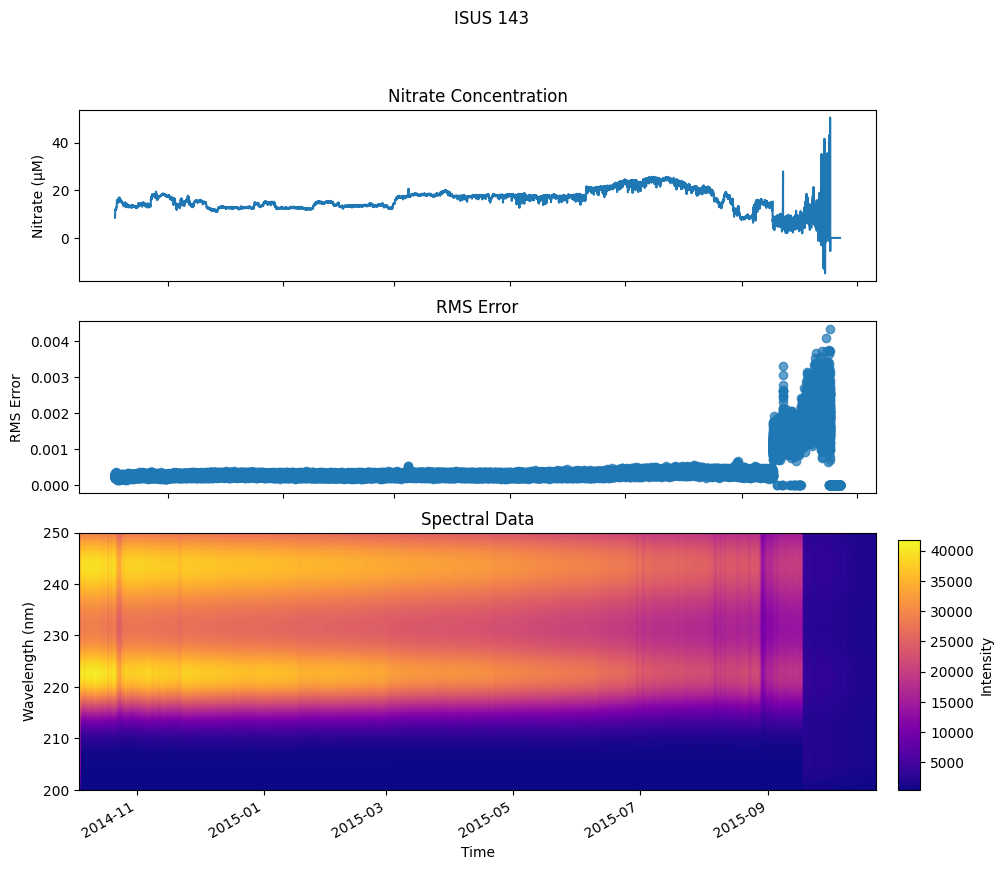

In [12]:
# Define save path
filename = datafile.split('/')[-1].replace('csv', 'raw_data.png')
savepath = f"images/{filename}"

isus_wop.plot_data(title=instrument, savepath=savepath)

**Applying RMSE Cutoff in `FilterSuna`**

Use the `FilterSuna` function to apply a Root Mean Square Error (RMSE) cutoff, filtering out data points with RMSE values higher than the specified threshold. The default cutoff is set at 0.00025, which may be too restrictive for some datasets. In this example, we start with an adjusted cutoff of 0.0003 to better accommodate the data.

Additionally, ensure that entries with an RMSE value of zero are removed as these are dark current values.

In [14]:
isus_wop_filtered = isus_wop.FilterIsus(rmse_cutoff=0.0006)

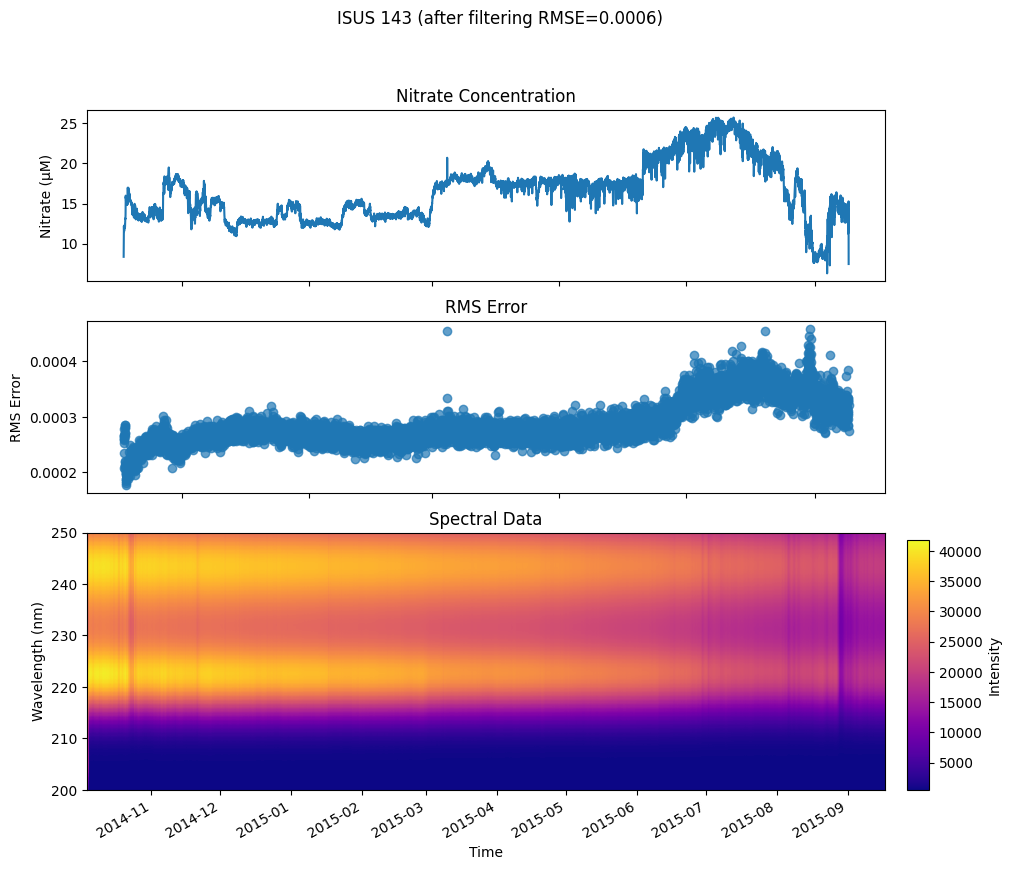

In [15]:
# Define save path
filename = datafile.split('/')[-1].replace('csv', 'raw_data_after_simple_screening.png')
savepath = f"images/{filename}"

# Plot filtered data
isus_wop.plot_data(title=instrument+" (after filtering RMSE=0.0006)", savepath=savepath)

**Read in calibration file**

The current example shows how to import the calibration file from automatic lookup. To use a local file instead, you can specify the file path as follows:

```python
user_provided_file = 'your/file/directory'
calibration_content = nitrates_parser.get_calibration_file(
    instrument, 
    data_year,
    user_provided_file=user_provided_file
)
```

In [17]:
calibration_content = nitrates_parser.get_calibration_file(
    instrument, 
    data_year,
    user_provided_file=user_cal_file    
)

ncal = nitrates_parser.parse_isus_cal(calibration_content)

In [18]:
ncal['CalTemp']

20.06910727047429

## 2. Load Co-located Mooring T/S Data

These mooring CTD files provide hourly temperature and salinity data, co-located with the SUNA measurements, and quality-controlled (QC-ed) using the SBE-16 instrument. Currently, this data is manually read from a local file. Future updates will include functionality for automatically locating and ingesting these files directly from the ERDDAP data server.

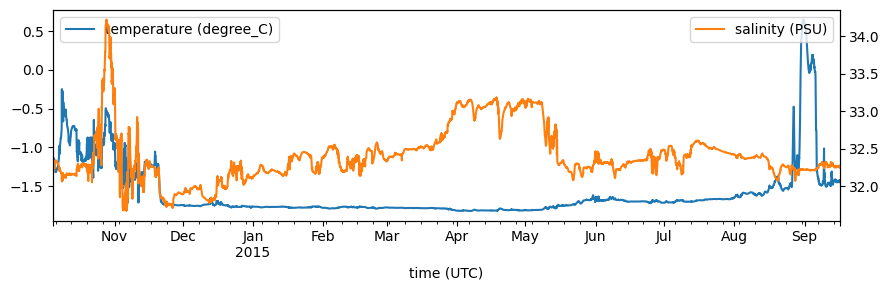

In [20]:
###############################################################
# from erddap
import EcoFOCIpy.io.erddap as erddap

remote=True

if remote:
    timeseries ={'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
                   'mooringid':'14ckp6a',
                   'qclevel':'final',
                   'instrid':'14ckp6a_sc_0039m'
                  }
    s16_df = erddap.erddapMooredInstretrieve(**timeseries)

    s16_df = s16_df.set_index(pd.DatetimeIndex(s16_df['time (UTC)']))

    try:
        s16_df.rename(columns={'salinity':'salinity (PSU)'},inplace=True) 
    except:
        pass
        
    # generate plots to quickly check the dataset
    fig, ax = plt.subplots(1, 1, figsize=(9, 3))
    s16_df['temperature (degree_C)'].plot(ax=ax)
    ax2 = ax.twinx()
    s16_df['salinity (PSU)'].plot(color='C1', ax=ax2)
    ax.legend()
    ax2.legend()
    fig.tight_layout()

else:
    ###############################################################
    # edit to point to {instrument sepcific} raw datafile on local
    datafile = user_data_dir+'.nc'
    ctd_instrument = 'SBE-16' 
    ###############################################################
    
    s16_df = xr.load_dataset(datafile, engine='netcdf4')
    
    # generate plots to quickly check the dataset
    fig, ax = plt.subplots(1, 1, figsize=(9, 3))
    s16_df['temperature'].plot(ax=ax)
    ax2 = ax.twinx()
    s16_df['salinity'].plot(color='C1', ax=ax2)
    ax.legend()
    ax2.legend()
    fig.tight_layout()

**Select key varialbes and transform structure**

Extract only the `temperature` and `salinity` variables from the dataset and convert them into a DataFrame format. Reset the index to organize data in a flattened structure. Then reshape data using a pivot table, and rename colums for clarity.

In [22]:
if remote:
    df = s16_df
    
else:
    df = s16_df[['temperature', 'salinity']].to_dataframe().reset_index()
    df = df.pivot_table(index='time')
    df.columns = ['Water_Depth (dbar)', 'latitude (degrees_north)', 'longitude (degrees_east)',
              'salinity (PSU)', 'temperature (degree_C)']

**Interpolating Data to Match Timestamps**

To align `s16_df` data with the timestamps in `suna_wop_filtered`, we need to first convert both indices to timezone-naive to ensure compatibility during reindexing. Then reindex `df` to match the index of `suna_wop_filtered`, filling in gaps through time-based interpolation. This allows for a smooth, continuous dataset aligned on a common timeline.

In [24]:
df.index = df.index.tz_localize(None)
isus_wop_filtered.index = isus_wop_filtered.index.tz_localize(None)

# s16_interpolated = df.reindex(isus_wop_filtered.index).interpolate(method='time')
# To avoid the warning message of the above line, use the following instead

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns
# Interpolate only numeric columns
s16_interpolated = (
    df[numeric_cols]
    .reindex(isus_wop_filtered.index)
    .interpolate(method='time')
)

## 3. Perform temperature and pressure corrections

Methods follow Plant et al. (2023): Updated temperature correction for computing seawater nitrate with in situ ultraviolet spectrophotometer and submersible ultraviolet nitrate analyzer nitrate sensors. Limnology and Oceanography: Methods.

Total absorption in seawater is modeled as a three-component mixture including absorbance due to sea salts (primarily bromide), nitrate, as well as a linear baseline component:
<div align="center">
    
$$
A_{\lambda, T, P} = b \left( \varepsilon_{S,\lambda,T,P} S + \varepsilon_{NO_3,\lambda} c_{NO_3} + f(\lambda) + e \right)
$$
</div>

**Step 1:** The function first calculates $\varepsilon_{S,\lambda,T,P}$ by 
<div align="center">

$$
\varepsilon_{S,\lambda, T, P} = \varepsilon_{\lambda, T_{\text{cal}}} \times e^{\left( f(\lambda') \cdot (T - T_{\text{cal}}) \right)} \times \left(1 - \frac{0.026 \times P}{1000}\right),
$$

</div>

where $\varepsilon_{\lambda, T_{\text{cal}}}$ is the calibrated extinction coefficient of sea water (read in from `ncal`), $T$ and $P$ are the measured temperature and pressure from the CTD file (read in from `s16_interpolated`). 

**Step 2:** Once the temperature and pressure correction is done for $\varepsilon_{S,\lambda, T, P}$, the function then compute the bromide componnet usint he observed salinity (from the CTD data `s16_interpolated`).
<div align="center">

$$
A_{\lambda, S} = \varepsilon_{S,\lambda,T,P} S
$$
</div>




**Step 3:**  The function then computes the total absorbance using 
<div align="center">

$$
A_{\lambda, T, P} = -\log_{10} \left( \frac{I_{\lambda} - I_D}{I_{\lambda,0} - I_D} \right),
$$
</div>

where $I_{\lambda}$ is the detector counts for light passing through the solution (measured data, read in through `suna_wop_filtered`), $I_{\lambda,0}$ is the detector intensity for a deionized water (DIW) blank (read in through `ncal`, the `Reference` column), and $I_D$ is intensity returned when the lamp is off (dark counts; read in through `suna_wop_filtered`).

**Step 4:** Finally, the function uses multiple regression to calculate the $e$ and $f$ values, which are base line coefficients that can be treated as adjustable parameters. Nitrate concentrations can be determined by fitting the above equation to the observed sample absorbance spectrum with a linear, least-squares optimization. 

In [26]:
(no3_concentration, WL_UV, E_N_interp, E_S_interp, ESW_in_situ, ESW_in_situ_p, 
 ABS_SW, ABS_Br_tcor, ABS_cor, spec_UV_INTEN) = nitrates_corr.calc_nitrate_concentration(
    isus_wop_filtered, s16_interpolated, ncal, inst_shortname=inst_shortname)

**Step 5:** After the correction is done, make a few plots to check results. A few sets show the following in order
1. Dark corrected intensity ($I_{\lambda} - I_D$) compared with reference values ($I_{\lambda,0} - I_D$)
2. Extinction coefficients
3. Total absorbancc
4. Bromide absorbance 
5. Nitrate and baseline absorbance
6. Corrected vs. original nitrate concentration
7. RMSE associated with corrected NO3 vs. original RMSE

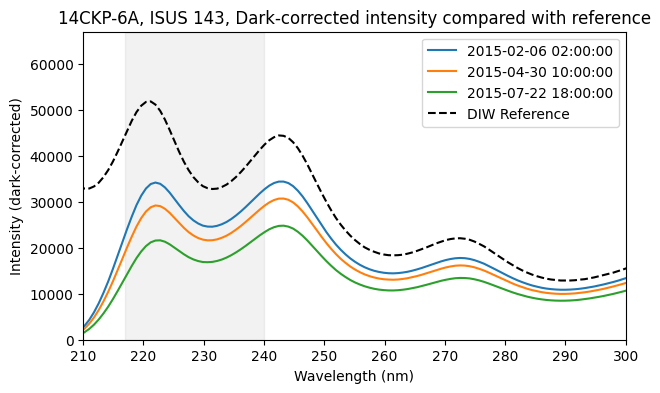

In [28]:
# User can specify a few random timestamps in order to check results. 
# Numbers should between 0 and the size of total timestamps (suna_wop_filtered.index)
timestamps = [3000, 5000, 7000]

# Define save path
filename = datafile.split('/')[-1].replace('csv', 'dark-corrected_intensity.png')
savepath = f"images/{filename}"

# Plot dark-corrected intensity
nitrates_corr.plot_intensity(ncal, isus_wop_filtered, timestamps, mooring_config, instrument, 
                             inst_shortname=inst_shortname, savepath=savepath)

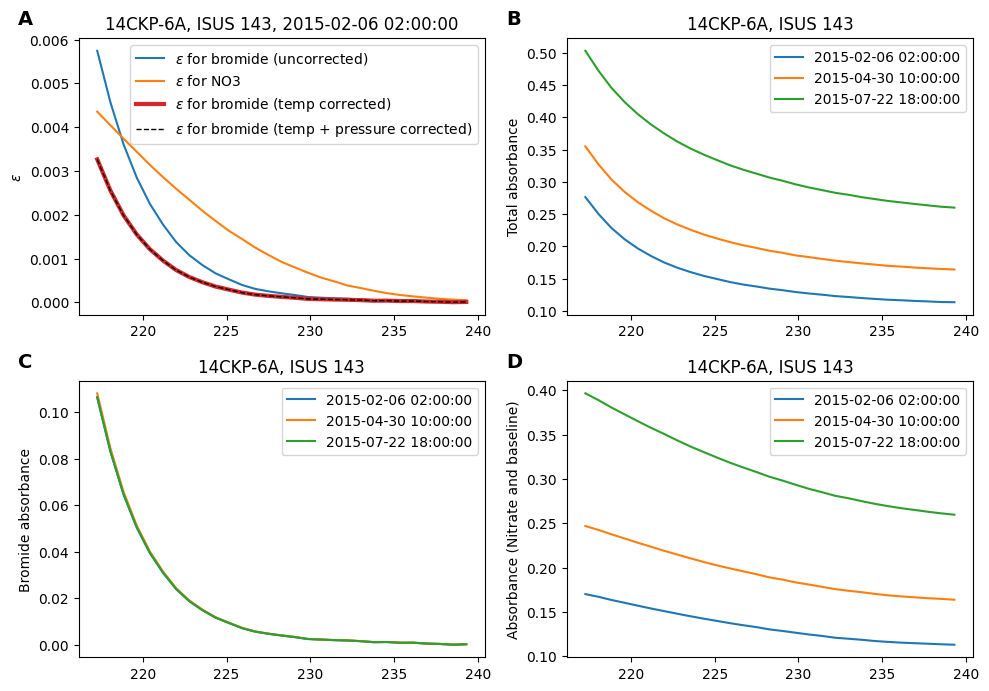

In [29]:
# Define save path
filename = datafile.split('/')[-1].replace('csv', 'coefficients_and_absorbance.png')
savepath = f"images/{filename}"

# Plot coefficients and absorbance
nitrates_corr.plot_corrected_data(WL_UV, E_S_interp, E_N_interp, ESW_in_situ, ESW_in_situ_p, 
                                  ABS_SW, ABS_Br_tcor, ABS_cor, isus_wop_filtered.index, timestamps, mooring_config, 
                                  instrument, savepath=savepath)

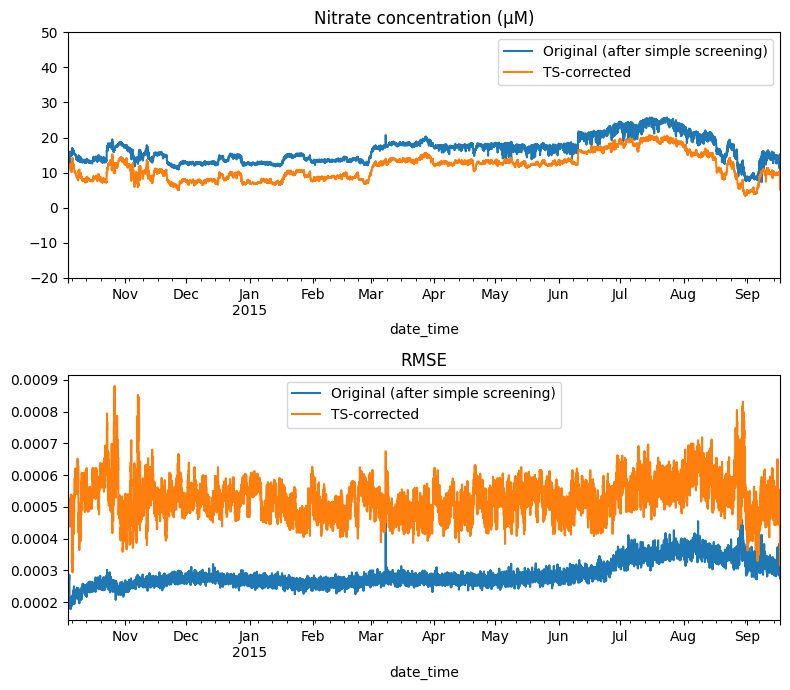

In [30]:
# Define save path
filename = datafile.split('/')[-1].replace('csv', 'TScorrected_vs_original_nitrate.png')
savepath = f"images/{filename}"

# Plot nitrate and assciated RMSE. 
# The default range of y-axis of nitrate plot is (0, 30). User could specify the range by using `ylim=(0,20)` for example.
nitrates_corr.plot_nitrate_and_rmse(isus_wop_filtered, no3_concentration,ylim=(-20,50), 
                                    inst_shortname=inst_shortname, savepath=savepath)

## 4. Perform quality control (QC) based on the new RMSE

A side product of the temperature and pressure correction is an RMSE, which could be used to further QC the nitrate concentration data. The `qc_nitrate` function filters and analyzes nitrate concentration data based on user-defined RMSE cutoff, smoothing parameters, and error band, then plot the results in three subplots.

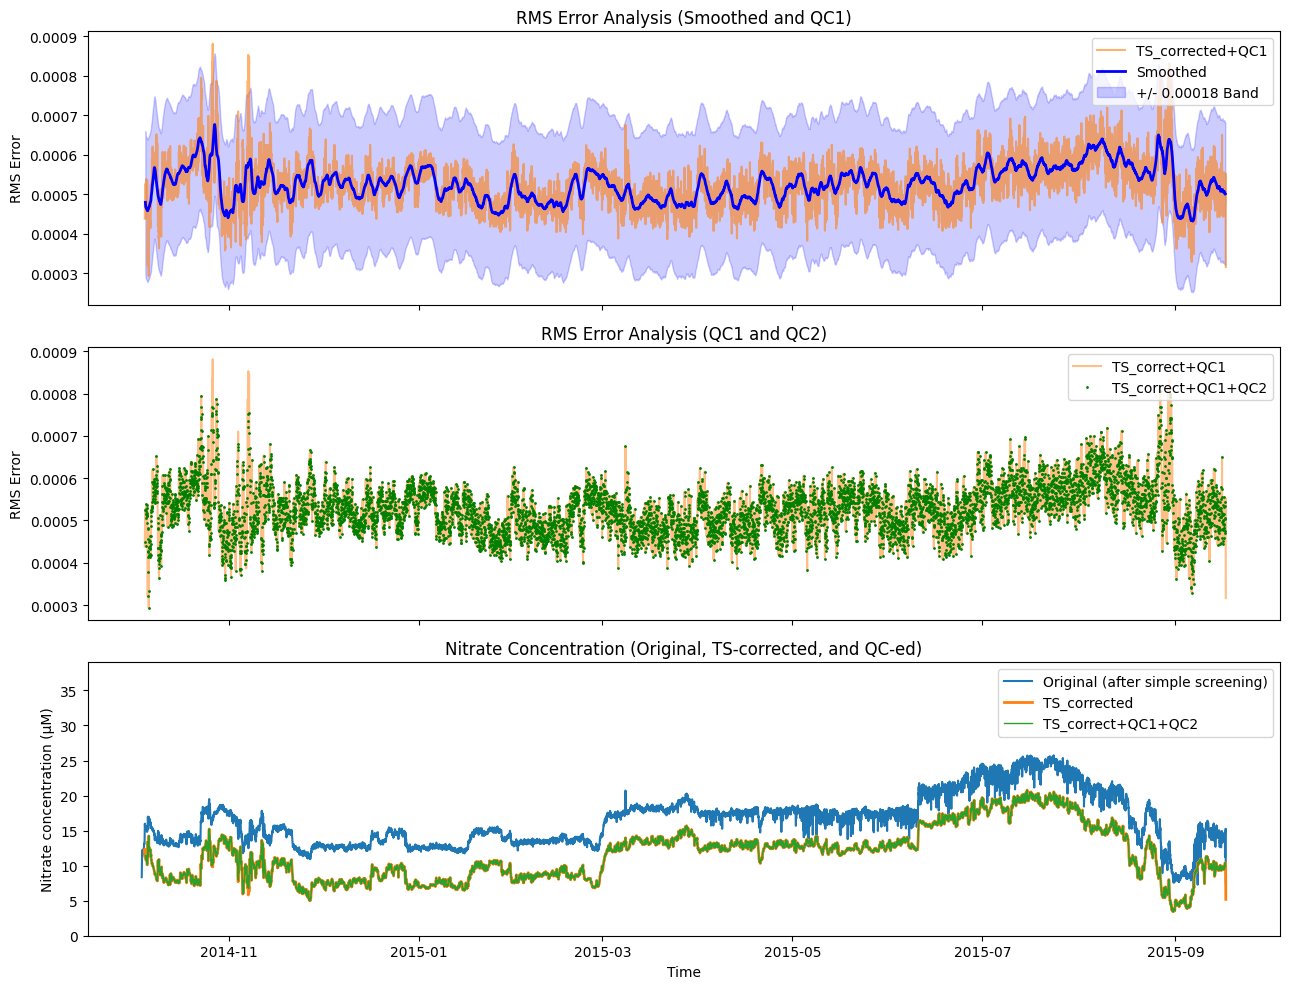

In [32]:
# User definable varialbes
rmse_cutoff=0.0035 # Values larger than this number will be filted. Default = 0.0035
window_size = 50   # Adjust based on how smooth you want the line to be. Use a larger value for further smoothing. Default = 50
error_bar = 0.00018 # RMSE +/- this value around the smoothed curve will be filted. 
                   # Use a smaller value to for stricter filtering. Default = 0.0002
ylim = (0, 39)     # This is the y-axis range of the third subplot for nitrate concentration

# Define save path
filename = datafile.split('/')[-1].replace('csv', 'QC1+QC2_based_on_new_RMSE.png')
savepath = f"images/{filename}"


no3_concentration_QC2 = nitrates_corr.qc_nitrate(
    no3_concentration, 
    isus_wop_filtered, 
    rmse_cutoff=rmse_cutoff, 
    window_size=window_size, 
    error_bar=error_bar,  
    ylim=ylim, 
    inst_shortname=inst_shortname,
    savepath=savepath
)

<div class="alert-info">
At this point, we've completed temperature and pressure corrections and have applied QC based on the newly-generated RMSE values. The next step is to use shipboard nitrate measurements for absolute value correction. This process requires expert QC experience to ensure accuracy and reliability. Given that data sources and formats can vary between deployments, this process is not fully automated. Instead, the following example demonstrates how to perform this step manually in a step-by-step approach.
</div>

## 5. Use nitrate measured by ship-board CTD casts to correct absolute values

For this deployment, we have access to measurements from the mooring recovery cruise (Sikuliaq, Fall 2023), along with data from an additional cruise in Summer 2023. Unfortunately, there are no measurements available from the initial deployment cruise. 

### Convert and Visualize CTD Cast Locations Relative to Mooring

This code block converts latitude and longitude values to decimal degrees for easier plotting and analysis, and then visualizes CTD cast locations relative to the mooring deployment point.

- **Latitude and Longitude Conversion**: The latitude and longitude columns in `recCast` are first converted to numeric values. Any non-numeric entries are coerced to `NaN` for error handling.
- **Helper Function `convert_to_degrees`**: This function converts coordinates from degrees, minutes, and direction format (e.g., `'71 12.95 N'`) to decimal degrees. It accounts for southern and western hemispheres by making those values negative.
- **Target Mooring Location**: The mooring location from `mooring_config` is converted to decimal degrees to serve as the target for visualization.
- **Plotting**: A scatter plot shows the locations of available CTD casts (`recCast`) and the mooring location (`target_lat`, `target_lon`) marked with an "x."

In [36]:
mooring_config

{'MooringID': '14CKP-6A',
 'Deployment': {'DeploymentCruise': 'AQ1401L2',
  'DeploymentLatitude': '71 46.60 N',
  'DeploymentLongitude': '161 52.74 W',
  'DeploymentDateTimeGMT': datetime.datetime(2014, 10, 4, 18, 47),
  'DeploymentDepth': 42.0},
 'Recovery': {'RecoveryCruise': 'AQ1501',
  'RecoveryLatitude': '71 46.60 N',
  'RecoveryLongitude': '161 52.74 W',
  'RecoveryDateTimeGMT': datetime.datetime(2015, 9, 17, 4, 0),
  'RecoveryDepth': 42.0},
 'Notes': '',
 'Instrumentation': {'30&quot; McClain xxxx': {'InstType': '30&quot; McClane Float',
   'SerialNo': 'xxxx',
   'DesignedDepth': 37.0,
   'ActualDepth': 0.0,
   'PreDeploymentNotes': '',
   'PostDeploymentNotes': '',
   'Deployed': 'y',
   'Recovered': 'y'},
  '36&quot; Syntactic float xxxx': {'InstType': '36&quot; Syntactic Float',
   'SerialNo': 'xxxx',
   'DesignedDepth': 36.0,
   'ActualDepth': 0.0,
   'PreDeploymentNotes': 'old style floats',
   'PostDeploymentNotes': '',
   'Deployed': 'y',
   'Recovered': 'y'},
  '8242AA r

In [37]:
# Load and display recovery cruise data

remote=True

if remote:
    dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
                   'cruiseid':'aq1401l2',
                   'qclevel':'final_nuts',
                   'concastno':'047'
                  }
    mid_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
                   'cruiseid':'rb1505',
                   'qclevel':'final_nuts',
                   'concastno':'109'
                  }
    rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
                   'cruiseid':'aq1501', 
                   'qclevel':'final_nuts',
                   'concastno':'007' 
                  }
                   
    depCast = erddap.erddapCTDretrieve(**dep_details)
    midCast = erddap.erddapCTDretrieve(**mid_details)
    recCast = erddap.erddapCTDretrieve(**rec_details)

    depCast.columns = [x.split()[0] for x in depCast.columns]
    midCast.columns = [x.split()[0] for x in midCast.columns]
    recCast.columns = [x.split()[0] for x in recCast.columns]

    # Fix longitude to [-180, 180] range
    for df in [depCast, midCast, recCast]:
        if 'longitude' in df.columns:
            df['longitude'] = np.where(df['longitude'] > 180, df['longitude'] - 360, df['longitude'])
else:
    recCast = pd.read_csv(user_data_dir + "../SUNA_22ckp3a/recCastCTD_NO3.csv", index_col=0)

In [38]:
depCast

,time,pressure,latitude,longitude,BTLID,Water_Depth,Station_Name,profile_id,SI,PO4,NO2,NO3,NH4,PO4_WOCE_FLAG,SI_WOCE_FLAG,NO3_WOCE_FLAG,NO2_WOCE_FLAG,NH4_WOCE_FLAG
256,2014-10-05T03:22:00Z,39.044,71.757835,-161.85066,1.0,NaN,NaN,aq1401l2c047_nut,32.6,1.539,0.23,4.5,4.35,NaN,NaN,NaN,NaN,NaN
257,2014-10-05T03:22:00Z,30.831,71.757835,-161.85066,2.0,NaN,NaN,aq1401l2c047_nut,29.6,1.488,0.24,4.2,4.06,NaN,NaN,NaN,NaN,NaN
258,2014-10-05T03:22:00Z,20.480,71.757835,-161.85066,3.0,NaN,NaN,aq1401l2c047_nut,12.6,0.803,0.08,0.6,0.16,NaN,NaN,NaN,NaN,NaN
259,2014-10-05T03:22:00Z,10.075,71.757835,-161.85066,4.0,NaN,NaN,aq1401l2c047_nut,6.6,0.448,0.02,0.0,0.05,NaN,NaN,NaN,NaN,NaN
260,2014-10-05T03:22:00Z,1.544,71.757835,-161.85066,5.0,NaN,NaN,aq1401l2c047_nut,6.5,0.444,0.05,0.0,0.07,NaN,NaN,NaN,NaN,NaN


In [39]:
midCast

,time,pressure,latitude,longitude,BTLID,Water_Depth,Station_Name,profile_id,SI,PO4,NO2,NO3,NH4
905,2015-08-30T08:30:08Z,38.0,71.76117,-161.83067,1.0,43.0,WT08,RB1505c109_nut,20.9,1.355,0.09,4.1,2.46
906,2015-08-30T08:30:08Z,38.0,71.76117,-161.83067,2.0,43.0,WT08,RB1505c109_nut,NaN,NaN,NaN,NaN,NaN
907,2015-08-30T08:30:08Z,30.0,71.76117,-161.83067,3.0,43.0,WT08,RB1505c109_nut,21.3,1.354,0.09,4.0,2.44
908,2015-08-30T08:30:08Z,23.0,71.76117,-161.83067,4.0,43.0,WT08,RB1505c109_nut,16.4,0.778,0.01,0.3,0.07
909,2015-08-30T08:30:08Z,23.0,71.76117,-161.83067,5.0,43.0,WT08,RB1505c109_nut,NaN,NaN,NaN,NaN,NaN
910,2015-08-30T08:30:08Z,10.0,71.76117,-161.83067,6.0,43.0,WT08,RB1505c109_nut,8.0,0.373,0.00,0.0,0.01
911,2015-08-30T08:30:08Z,3.0,71.76117,-161.83067,7.0,43.0,WT08,RB1505c109_nut,7.8,0.359,0.00,0.0,0.01
912,2015-08-30T08:30:08Z,2.0,71.76117,-161.83067,8.0,43.0,WT08,RB1505c109_nut,NaN,NaN,NaN,NaN,NaN


In [40]:
# Remove roles with NaN data values
midCast = midCast.dropna(subset=['NO3'])
midCast

,time,pressure,latitude,longitude,BTLID,Water_Depth,Station_Name,profile_id,SI,PO4,NO2,NO3,NH4
905,2015-08-30T08:30:08Z,38.0,71.76117,-161.83067,1.0,43.0,WT08,RB1505c109_nut,20.9,1.355,0.09,4.1,2.46
907,2015-08-30T08:30:08Z,30.0,71.76117,-161.83067,3.0,43.0,WT08,RB1505c109_nut,21.3,1.354,0.09,4.0,2.44
908,2015-08-30T08:30:08Z,23.0,71.76117,-161.83067,4.0,43.0,WT08,RB1505c109_nut,16.4,0.778,0.01,0.3,0.07
910,2015-08-30T08:30:08Z,10.0,71.76117,-161.83067,6.0,43.0,WT08,RB1505c109_nut,8.0,0.373,0.00,0.0,0.01
911,2015-08-30T08:30:08Z,3.0,71.76117,-161.83067,7.0,43.0,WT08,RB1505c109_nut,7.8,0.359,0.00,0.0,0.01


In [41]:
recCast

,time,pressure,latitude,longitude,BTLID,Water_Depth,Station_Name,profile_id,SI,PO4,NO2,NO3,NH4
35,2015-09-17T04:43:10Z,37.0,71.774666,-161.86766,1.0,42.0,14CK-6A,AQ1501c007_nut,28.9,1.474,0.12,7.4,4.46
36,2015-09-17T04:43:10Z,30.0,71.774666,-161.86766,3.0,42.0,14CK-6A,AQ1501c007_nut,26.3,1.413,0.12,7.2,3.66
37,2015-09-17T04:43:10Z,20.0,71.774666,-161.86766,4.0,42.0,14CK-6A,AQ1501c007_nut,10.2,0.622,0.02,0.8,0.40
38,2015-09-17T04:43:10Z,10.0,71.774666,-161.86766,6.0,42.0,14CK-6A,AQ1501c007_nut,5.2,0.483,0.00,0.0,0.09
39,2015-09-17T04:43:10Z,2.0,71.774666,-161.86766,7.0,42.0,14CK-6A,AQ1501c007_nut,5.2,0.489,0.00,0.0,0.06


In [42]:
# Function to convert recovery latitude and longitude to decimal degrees
def convert_to_degrees(coordinate):
    # Split the string by spaces to get degrees, minutes, and direction
    parts = coordinate.split()
    degrees = float(parts[0])
    minutes = float(parts[1])
    direction = parts[2].upper()

    # Calculate the decimal degree value
    decimal_degrees = degrees + minutes / 60.0

    # Adjust based on direction
    if direction in ['S', 'W']:
        decimal_degrees = -decimal_degrees

    return float(decimal_degrees)

# find the mooring location as the target
target_lat = convert_to_degrees(mooring_config['Deployment']['DeploymentLatitude'])
target_lon = convert_to_degrees(mooring_config['Deployment']['DeploymentLongitude'])

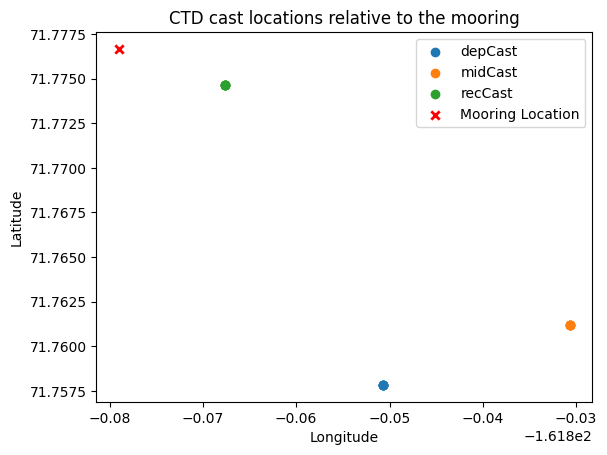

In [43]:
# Create an image showing the location of mooring and available CTD casts
casts = [
    (depCast, 'depCast'),
    (midCast, 'midCast'),
    (recCast, 'recCast')
]

# Create an image showing the location of mooring and available CTD casts
for cast, label in casts:
    plt.scatter(cast['longitude'], cast['latitude'], label=label)

plt.scatter(target_lon, target_lat, marker='x', lw=2, color='red', label="Mooring Location")
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.legend()
plt.title('CTD cast locations relative to the mooring')

# Define save path
filename = datafile.split('/')[-1].replace('csv', 'CTD_cast_locations.png')
savepath = f"images/{filename}"
plt.savefig(savepath, dpi=150, bbox_inches='tight')
plt.show()

### Define offset value, and shift the curve to mannually match the bottled values

In [45]:
# Function to generate list of refne
def extract_reference_point(cast_df, depth):
    """
    Extract the nearest nitrate value and rounded time from a cast DataFrame.
    """
    idx = (cast_df['pressure'] - depth).abs().argsort().iloc[0]
    time = pd.to_datetime(cast_df.iloc[idx]['time'], format='%Y-%m-%dT%H:%M:%SZ').round('1h')
    value = cast_df.iloc[idx]['NO3']
    return (time, value)

In [46]:
# Find the instrument deployment depth
# Note: Use 'DesignedDepth' instead of 'ActualDepth' as missing pressure sensors
# depth = mooring_config['Instrumentation'][instrument]['ActualDepth']
depth = mooring_config['Instrumentation'][instrument]['DesignedDepth']
print(f'Sensor depth = {depth}')

# Generate the reference points
casts = [depCast, midCast, recCast]
reference_points = [extract_reference_point(cast, depth) for cast in casts]

mean_offset = nitrates_corr.calculate_mean_offset(
    curve_data=no3_concentration_QC2['Nitrate concentration (μM)'],
    reference_points=reference_points,
    max_timedelta=pd.Timedelta(days=2)  # optional limit
)
print(f'mean_offset = {mean_offset}')

Sensor depth = 39.0
Ref time: 2014-10-05 03:00:00 | Closest non-NaN: 2014-10-05 06:00:00 | Curve value: 11.431 | Ref value: 4.5 | Offset: 6.931
Ref time: 2015-08-30 09:00:00 | Closest non-NaN: 2015-08-30 09:00:00 | Curve value: 4.555 | Ref value: 4.1 | Offset: 0.455
Ref time: 2015-09-17 05:00:00 | Closest non-NaN: 2015-09-17 00:00:00 | Curve value: 9.867 | Ref value: 7.4 | Offset: 2.467
mean_offset = 3.284265669769925


#### Perform the last QC process: remove the negative values

In [48]:
no3_concentration_QC3 = no3_concentration_QC2[['Nitrate concentration (μM)']] - mean_offset
no3_concentration_QC3 = no3_concentration_QC3[(no3_concentration_QC3 >= 0) | (no3_concentration_QC3.isna())]

In [49]:
# Create a string buffer to capture stdout
buffer = io.StringIO()

# Call the function and capture both printed output and return value
with redirect_stdout(buffer):
    mean_offset = nitrates_corr.calculate_mean_offset(
        curve_data=no3_concentration_QC2['Nitrate concentration (μM)'],
        reference_points=reference_points,
        max_timedelta=pd.Timedelta(days=2)
    )
    print(f'mean_offset = {mean_offset:.2f}')
    
# Get the printed output as a single string
offset_text = buffer.getvalue()

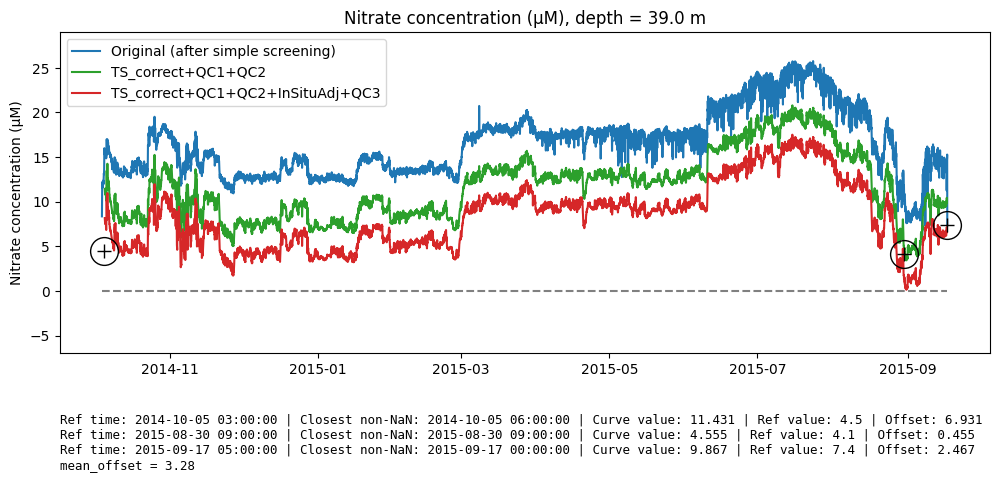

In [50]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])  # plot gets more space
gs.update(hspace=0.3)

# Create the main plot
ax = fig.add_subplot(gs[0])

# Plot the original and adjusted curves along with reference points
ax.plot(isus_wop_filtered.index, isus_wop_filtered['NO3_conc'], 
        label='Original (after simple screening)')
ax.plot(no3_concentration_QC2.index, no3_concentration_QC2['Nitrate concentration (μM)'], 
        label='TS_correct+QC1+QC2', color='C2')
ax.plot(no3_concentration_QC3.index, no3_concentration_QC3, 
        label='TS_correct+QC1+QC2+InSituAdj+QC3', color='C3')

for ref_index, ref_value in reference_points:
    ax.plot(ref_index, ref_value, 'o', markersize=20, markerfacecolor='none', markeredgecolor='k')
    ax.plot(ref_index, ref_value, '+', markersize=10, markerfacecolor='none', markeredgecolor='k')

# Customize the plot
ax.hlines(0,no3_concentration_QC3.index.min(),no3_concentration_QC3.index.max(),'grey','--')
ax.set(ylabel='Nitrate concentration (μM)', 
       title='Nitrate concentration (μM), depth = {} m'.format(depth), 
       ylim=[-7, 29])
ax.legend()

# Add a dedicated text box below the plot
text_ax = fig.add_subplot(gs[1])
text_ax.axis('off')  # Hide axes for the text panel
text_ax.text(0, 1, offset_text, fontsize=9, family='monospace', va='top', ha='left')

# Define save path
filename = datafile.split('/')[-1].replace('csv', 'nitrate_final_with_offset.png')
savepath = f"images/{filename}"
fig.savefig(savepath, dpi=150, bbox_inches='tight')
plt.show()

### Plot the final curve, along with the mooring T/S data

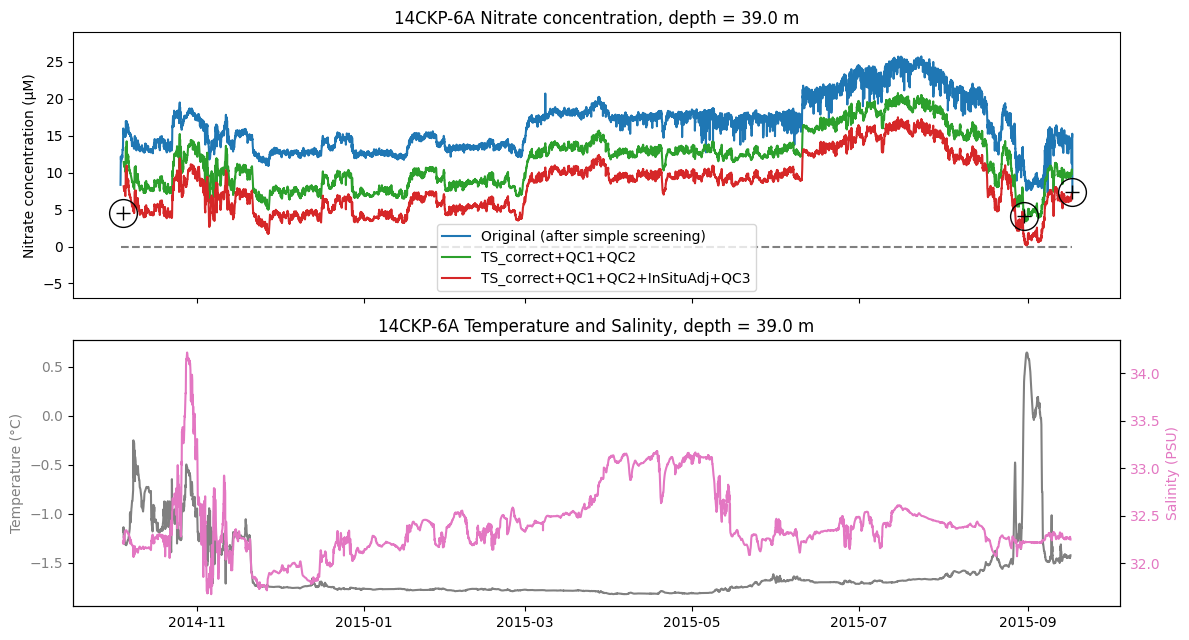

In [52]:
fig, axes = plt.subplots(2, figsize=(12, 6.5), sharex=True)

ax = axes[0]
# Plot the original and adjusted curves along with reference points
ax.plot(isus_wop_filtered.index, isus_wop_filtered['NO3_conc'],  
        label='Original (after simple screening)')
ax.plot(no3_concentration_QC2.index, no3_concentration_QC2['Nitrate concentration (μM)'], 
        label='TS_correct+QC1+QC2', color='C2')
ax.plot(no3_concentration_QC3.index, no3_concentration_QC3, 
        label='TS_correct+QC1+QC2+InSituAdj+QC3', color='C3')

for ref_index, ref_value in reference_points:
    ax.plot(ref_index, ref_value, 'o', markersize=20, markerfacecolor='none', markeredgecolor='k')
    ax.plot(ref_index, ref_value, '+', markersize=10, markerfacecolor='none', markeredgecolor='k')

# Customize the plot
ax.hlines(0,no3_concentration_QC3.index.min(),no3_concentration_QC3.index.max(),'grey','--')
ax.legend()
ax.set(ylabel='Nitrate concentration (μM)', 
       title='{} Nitrate concentration, depth = {} m'.format(mooring_config['MooringID'], depth),
       ylim=[-7, 29])


ax = axes[1]
color = 'gray'
ax.plot(s16_df.index, s16_df['temperature (degree_C)'],color = color)
ax.set_ylabel('Temperature (°C)', color = color)
ax.tick_params(axis='y', labelcolor = color)
ax.set(title='{} Temperature and Salinity, depth = {} m'.format(mooring_config['MooringID'], depth))

color = 'C6'
ax2 = ax.twinx()
ax2.plot(s16_df.index, s16_df['salinity (PSU)'],color = color)
ax2.set_ylabel('Salinity (PSU)', color = color)
ax2.tick_params(axis='y', labelcolor = color)
ax2.set(title='')

fig.tight_layout()

# Define save path
filename = datafile.split('/')[-1].replace('csv', 'nitrate_final_TS.png')
savepath = f"images/{filename}"
fig.savefig(savepath, dpi=150, bbox_inches='tight')
plt.show()

## 6. Output Final NO3 to csv and netcdf

In [54]:
PI_Vetted = no3_concentration_QC3
PI_Vetted = PI_Vetted.rename(columns={'Nitrate concentration (μM)': 'nitrate'})
datafile_r = datafile.split('/')[-1].replace('.csv','.NOxCal.csv')
PI_Vetted.to_csv(f'{datafile_r}')

### Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [56]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

institution_config

{'source_documents': 'http://www.oceansites.org/docs/oceansites_data_format_reference_manual.pdf',
 'institution': 'Pacific Marine Environmental Lab (PMEL)',
 'project': 'EcoFOCI',
 'project_url': 'https://www.ecofoci.noaa.gov',
 'principal_investigator': 'Phyllis Stabeno',
 'principal_investigator_email': 'phyllis.stabeno (at) noaa.gov',
 'creator_name': 'Shaun Bell',
 'creator_email': 'shaun.bell (at) noaa.gov',
 'creator_institution': 'PMEL',
 'keywords': 'Mooring, Oceanographic',
 'comment': 'Provisional data',
 'sea_area': 'Bering Sea (BS)',
 'featureType': 'timeSeries',
 'conventions': '”CF-1.6, ~OceanSITES-1.5, ACDD-1.2”',
 'license': '',
 'references': '',
 'citation': '',
 'acknowledgement': ''}

In [57]:
# Update some fields
institution_config.update({
    'source_documents': 'https://repository.oceanbestpractices.org/bitstream/handle/11329/874.2/oceansites_data_format_reference_manual.pdf?sequence=5&isAllowed=y',
    'creator_name': 'Jiaxu Zhang',
    'creator_email': 'jiaxu.zhang (at) noaa.gov',
    'comment': 'Final QC version',
    'sea_area': 'Chukchi Sea (CS)',
    'conventions': 'CF-1.6, OceanSITES-1.5, ACDD-1.2',
    'license': 'CC-BY-4.0'
})

In [58]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [59]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
isus_data_nc = ncCFsave.EcoFOCI_CFnc(df=PI_Vetted, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config, 
                                operation_type='mooring',
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
isus_data_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [61]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
isus_data_nc.expand_dimensions()

In [62]:
# isus_data_nc.variable_meta_data(variable_keys=list(PI_Vetted.columns.values),drop_missing=True)
isus_data_nc.variable_meta_data(variable_keys=list(PI_Vetted.columns.values),drop_missing=False)
isus_data_nc.temporal_geospatioal_meta_data()
#adding dimension meta needs to come after updating the dimension values... BUG?
isus_data_nc.dimension_meta_data(variable_keys=['time','depth','latitude','longitude'])

In [63]:
isus_data_nc

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [65]:
#add global attributes
isus_data_nc.deployment_meta_add()
isus_data_nc.get_xdf()

#add instituitonal global attributes
isus_data_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
isus_data_nc.instrument_meta_data()

#add creation date/time - provenance data
isus_data_nc.provinance_meta_add()

#provide intial qc status field
isus_data_nc.qc_status(qc_status='unknown')


### Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [67]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

# depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# Temp fix
depth = str(int(mooring_config['Instrumentation'][instrument]['DesignedDepth'])).zfill(4)

# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
isus_data_nc.xarray2netcdf_save(xdf = isus_data_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")